#### drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Imports & Global Setting

In [2]:
!pip install lightgbm
!pip install catboost
!pip install xgboost
!pip install shap
!pip install tqdm


In [3]:
import os
import random
import pickle
import gzip
import gc
import re
import warnings
warnings.filterwarnings("ignore")  # 불필요한 경고 메시지 숨김

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from tqdm import tqdm, tqdm_notebook



from sklearn.impute import SimpleImputer  # 결측값 처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder  # 데이터 스케일링 & 인코딩
from sklearn.cluster import KMeans  # 군집화 (클러스터링)
from lightgbm import LGBMClassifier  # LightGBM
from catboost import CatBoostClassifier  # CatBoost
from xgboost import XGBClassifier  # XGBoost
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier  # 앙상블 모델
from sklearn.model_selection import cross_val_score, KFold  # 교차 검증 (K-Fold)
from sklearn.metrics import accuracy_score  # 정확도 평가
import shap  # SHAP 값 계산을 통한 피처 중요도 분석
%matplotlib inline


### 데이터 설명
- **패널(Panel) 데이터**
  - userID: 패널 ID
  - BIRTH: 생일(연도)
  - GENDER: 1(남자) 2(여자)
  - REGION: 거주지역
  - TYPE: 패널 구분
  - SQ1 ~ DQ7: 패널 가입 시 설문조사 데이터 상세정보 참가자에 한하여 제공
- **설문(Survey) 데이터**
  - surveyID: 설문 ID
  - TITLE: 설문 제목
  - IR: 난이도(응답가능성, 100이 최고)
  - LOI: 설문하는데 걸리는 시간 (분단위)
  - CATEGORIES: 설문 분류
  - CPI: 패널 응답 리워드 포인트(1P~)
- **응답(Response) 데이터**
  - STATUS: 응답여부 (Target)
  - (test 데이터의) ID: submission을 식별하기 위한 ID로 사용

# 01. Data Loading

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023KML/data/train.csv', encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023KML/data/test.csv', encoding='cp949')

In [5]:
train.shape

(813650, 44)

In [6]:
original_features = train.columns
original_features

Index(['userID', 'surveyID', 'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ1', 'SQ2',
       'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4',
       'B5', 'C1', 'C2', 'C3', 'F1', 'F2', 'H1', 'T1', 'X1', 'X2', 'X3', 'X4',
       'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6', 'DQ7', 'TITLE', 'IR', 'LOI',
       'CATEGORIES', 'CPI', 'STATUS'],
      dtype='object')

# 02. Data Preprocessing

##### Clean data & derive features

In [7]:
# 결측값 비율이 30% 이하인 column만 사용(사용할 피처들만 출력)
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] <= 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

userID 	 15155 	 0.0
surveyID 	 1293 	 0.0
BIRTH 	 76 	 0.0
GENDER 	 2 	 0.0
REGION 	 17 	 0.0
TYPE 	 3 	 0.0
SQ1 	 2 	 0.0009770785964481042
SQ2 	 82 	 0.0014293615190806859
SQ3 	 47 	 0.09023044306520002
SQ4 	 52 	 0.09058931973207153
SQ5 	 273 	 0.14450930989983407
SQ6 	 30 	 0.14490751551649972
SQ7 	 1234 	 0.1802556381736619
SQ8 	 1774 	 0.1831610643397038
A1 	 2768 	 0.2083279051189086
B1 	 131 	 0.21447796964296686
B2 	 120 	 0.2426792847047256
B3 	 110 	 0.24790757696798377
B4 	 715 	 0.2602888219750507
B5 	 669 	 0.26743317151109197
TITLE 	 1286 	 0.0
IR 	 42 	 0.0
LOI 	 26 	 0.0
CPI 	 43 	 0.0
STATUS 	 2 	 0.0


In [8]:
# 불필요한 ID들은 제외. SQ1 ~ SQ3는 GENDER, BIRTH, REGION과 중복이어서 제외!
# features.remove('userID')
# features.remove('surveyID')
features.remove('STATUS')
features.remove('SQ1')
features.remove('SQ2')
features.remove('SQ3')

###  공백 및 오입력 처리: 프로파일 데이터 전처리

- **SQ4**: 거주 주택 형태
- **SQ5**: 최종학력
- **SQ6**: 결혼여부
- **SQ7**: 자녀 수
- **SQ8**: 가족 수


In [9]:
def clean_profile_column(col, valid_vals, default_val=99):
    def cleaner(x):
        x_str = str(x).strip().replace(',', '').split('.')[0]
        return int(x_str) if x_str in valid_vals else default_val
    return col.apply(cleaner)

In [10]:
valid_sq4 = [str(i) for i in range(1, 7)]
valid_sq5 = [str(i) for i in range(1, 5)]
valid_sq6 = ['1', '2']
valid_sq7 = [str(i) for i in range(1, 17)]

for df in [train, test]:
    df['SQ4'] = clean_profile_column(df['SQ4'], valid_sq4)
    df['SQ5'] = clean_profile_column(df['SQ5'], valid_sq5)
    df['SQ6'] = clean_profile_column(df['SQ6'], valid_sq6)
    df['SQ7'] = clean_profile_column(df['SQ7'], valid_sq7)


- 피처별 유효값 기준 정리 및 오입력 전처리

In [11]:
# 최근 구입/렌트 가전제품: 1~22/99 정상값
values = pd.Series(range(1,23)).apply(lambda x: str(x)).tolist()
def handle_profile(x):
    if x in values:
        return int(x)
    else:
        return 99

train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [12]:
# 휴대폰 통신망 종류: 1~8/99 정상값
def handle_profile(x):
    if x in ['1']:
        return 2
    elif x in ['2', '3']:
        return 3
    elif x in ['4', '5', '6', '7']:
        return 4
    elif x in ['8']:
        return 5
    else:
        return 99

train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [13]:
# 가입한 이동통신사: 1~6/97 정상값
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    else:
        return 99

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [14]:
# 휴대폰 브랜드: 1~7/97/99
def handle_profile(x):
    if x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

In [15]:
# 보유 스마트 기기: 1~7/97/99
def handle_profile(x):
    if x != x :
        return 0
    elif x in ['1', '2', '3', '4', '5', '6', '7' , '99', '97']:
        return int(x)
    else:
        return 98

train.B4 = train.B4.apply(handle_profile)
test.B4 = test.B4.apply(handle_profile)

In [16]:
# 케이블TV: 1~10/97/99
def handle_profile(x):
    if x != x :
        return 0
    elif x in ['1', '2', '3', '4' ,'5', '6', '7', '8', '9', '10']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,' ,'5,', '6,', '7,', '8,', '9,', '10,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B5 = train.B5.apply(handle_profile)
test.B5 = test.B5.apply(handle_profile)

In [17]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '7,', '8,', '9,', '10,', '11,', '12,', '13,', '14,']:
        return int(x[0])
    else:
        return 99

train.C1 = train.C1.apply(handle_profile)
test.C1 = test.C1.apply(handle_profile)

In [18]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '7,', '8,', '9,', '10,', '11,', '12,', '13,', '14,']:
        return int(x[0])
    else:
        return 99

train.C2 = train.C2.apply(handle_profile)
test.C2 = test.C2.apply(handle_profile)

In [19]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,', '7,', '8,', '9,', '10,']:
        return int(x[0])
    else:
        return 99

train.C3 = train.C3.apply(handle_profile)
test.C3 = test.C3.apply(handle_profile)

### **< train_TITLE >** 피처

In [20]:
train_TITLE = train.copy()
test_TITLE = test.copy()

# 03. 피처추가 Feature Generation(FE_GN)

#### 01. 'panel_response_rate' : 응답률(RESRATE) 구간화

In [21]:
# 01. [panel_response_rate] : 응답률(RESRATE) 구간화

res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('userID')['userID'].agg([('SEND',np.size)]).reset_index()

train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'RESRATE']], how='left')
test['RESRATE'] = test['RESRATE'].fillna(0)

#features.extend(['RESRATE'])    --> 피처 추가는 round된 버전으로!

# 구간화
train['panel_response_rate'] = round(train['RESRATE'], 3)
test['panel_response_rate'] = round(test['RESRATE'], 3)

features.extend(['panel_response_rate'])


In [22]:
print(train['RESRATE'].nunique())
print(train['panel_response_rate'].nunique())

2441
933


#### 02. 'survey_response_rate'

In [23]:
# 설문별 응답률 (RESRATE_S) 생성
res_freq = train.query('STATUS == 1').groupby('surveyID')['surveyID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('surveyID')['surveyID'].agg([('SEND',np.size)]).reset_index()

train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE_S'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']

test = pd.merge(test, train.drop_duplicates(subset=['surveyID'])[['surveyID', 'RESRATE_S']], how='left')
test['RESRATE_S'] = test['RESRATE_S'].fillna(0)

features.extend(['RESRATE_S'])

# RESRATE_S 구간화 <- (예.0.3389와 0.3888은 같은 값으로 취급하는 것이 합리적임)
train['survey_response_rate'] = round(train['RESRATE_S'],3)
test['survey_response_rate'] = round(test['RESRATE_S'],3)

features.extend(['survey_response_rate'])


#### 03. 'type_response_rate' : 타입별 응답률

In [24]:
# 03. ['type_response_rate'] : 타입별 응답률

response = train.groupby('TYPE')['STATUS'].agg([('type_response_rate', lambda x: np.mean(x))]).reset_index()
train = train.merge(response, how='left', on='TYPE')
test = test.merge(response, how='left', on='TYPE')

features.extend(['type_response_rate'])


#### 04. 'reward_per_time'

In [25]:
# 04. ['reward_per_time']: 단위 시간당 리워드

train['reward_per_time'] = train['CPI'] / train['LOI']
test['reward_per_time'] = test['CPI'] / test['LOI']
features.extend(['reward_per_time'])


#### 05.'neg_scaled_time_difficulty'

In [26]:
# 05. ['neg_scaled_time_difficulty']: -(scaled IR + LOI) feature

# IR 피처에 대한 Min-Max Scaling (범위: 1~35)
scaler = MinMaxScaler(feature_range=(1, 35))  # LOI 범위에 맞춰 스케일링
train['IR_scaled'] = scaler.fit_transform(train['IR'].values.reshape(-1, 1))
test['IR_scaled'] = scaler.fit_transform(test['IR'].values.reshape(-1, 1))

# IR_scaled와 LOI의 합에 음수 부호를 붙여 새로운 피처 생성
train['neg_scaled_time_difficulty'] = -(train['IR_scaled'] + train['LOI'])
test['neg_scaled_time_difficulty'] = -(test['IR_scaled'] + test['LOI'])

# 피처 리스트에 추가
features.extend(['neg_scaled_time_difficulty'])


#### 06. 'target_region', 'target_type_general', 'target_type_consumer'

In [27]:
# 06. ['target_region', 'target_type_general', 'target_type_consumer']

# 키워드 매핑
keywords = {
    'target_region': ('해외', 'overseas'),
    'target_type_general': ('일반인', 'general'),
    'target_type_consumer': ('소비자', 'consumer')
}

# train, test 각각 처리
for df, title_df in zip([train, test], [train_TITLE, test_TITLE]):
    for col, (keyword, label) in keywords.items():
        df[col] = np.where(title_df['TITLE'].str.contains(keyword), label, 'other')

# 피처 리스트 추가
features.extend(['target_region', 'target_type_general', 'target_type_consumer'])



#### 07. 'Points_earned_bins'

In [28]:
# 07. '[Points_earned_bins'] : 패널 ID 별 획득 누적 포인트

#Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()
Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned, how='left')
train = train.merge(Points_earned_mean, how='left')
train['Points_earned'].fillna(0, inplace = True)
train['Points_earned_mean'].fillna(0, inplace = True)

test = test.merge(Points_earned, how='left')
test = test.merge(Points_earned_mean, how='left')
test['Points_earned'].fillna(0, inplace = True)
test['Points_earned_mean'].fillna(0, inplace = True)

#features.extend(['Points_earned_mean'])

'''구간화'''
# 0부터 1170까지는 20씩, 1200에서 2000까지는 하나의 구간으로 설정
bin_edges = list(range(0, 1200, 20)) + [2000]

# 구간에 대한 라벨 설정
bin_labels = [f'{i}-{i+19}' for i in range(0, 1180, 20)] + ['1200-2000']

# 'Points_earned_mean' 열을 구간화하여 새로운 열로 추가
train['Points_earned_bins'] = pd.cut(train['Points_earned_mean'], bins=bin_edges, labels=bin_labels, include_lowest=True)
test['Points_earned_bins'] = pd.cut(test['Points_earned_mean'], bins=bin_edges, labels=bin_labels, include_lowest=True)

features.append('Points_earned_bins')

#### 08. 'Status_sum_log'

In [29]:
# 08. 응답 횟수(참여 횟수) 계산
Status_sum = train.groupby('userID')['STATUS'].sum()

# 데이터에 병합
train = train.merge(Status_sum.rename('Status_sum'), on='userID', how='left')
test = test.merge(Status_sum.rename('Status_sum'), on='userID', how='left')

# 로그 변환 후 새로운 피처 생성
train['Status_sum_log'] = np.log(train['Status_sum'] + 1)
test['Status_sum_log'] = np.log(test['Status_sum'] + 1)

# 피처 리스트에 추가
features.extend(['Status_sum_log'])


In [30]:
train.columns

Index(['userID', 'surveyID', 'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ1', 'SQ2',
       'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4',
       'B5', 'C1', 'C2', 'C3', 'F1', 'F2', 'H1', 'T1', 'X1', 'X2', 'X3', 'X4',
       'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6', 'DQ7', 'TITLE', 'IR', 'LOI',
       'CATEGORIES', 'CPI', 'STATUS', 'RESRATE', 'panel_response_rate',
       'RESRATE_S', 'survey_response_rate', 'type_response_rate',
       'reward_per_time', 'IR_scaled', 'neg_scaled_time_difficulty',
       'target_region', 'target_type_general', 'target_type_consumer',
       'Points_earned', 'Points_earned_mean', 'Points_earned_bins',
       'Status_sum', 'Status_sum_log'],
      dtype='object')

In [31]:
# Survey 제목에서 유용한 정보 추출
word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score

train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

# 04. 데이터 필터링


In [32]:
#데이터 필터링
X_train = train[features]
X_test = test[features]
y_train = train['STATUS']

# submission을 만들 때 사용하기 위해 ID 저정
ID_test = test.ID

# 메모리 낭비를 막기위해 불필요한 데이터 삭제
del train, test
gc.collect()

4

# 05. Feature Engineering

In [33]:
def separate_features(df):
    num_features = df.select_dtypes(include=['int', 'float']).columns.tolist()
    cat_features = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
    return num_features, cat_features


num_features, cat_features = separate_features(X_train)

In [34]:
print(len(num_features))
print(len(cat_features))

24
8


##### 1) Impute missing values

In [35]:
# 범주형이냐 수치형이냐에 따라 다르게 처리
if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])
if len(cat_features) > 0:
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_features] = imp.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp.transform(X_test[cat_features])


X_train['GENDER'] = X_train['GENDER'].astype(int)
X_train['REGION'] = X_train['REGION'].astype(int)
X_test['GENDER'] = X_test['GENDER'].astype(int)
X_test['REGION'] = X_test['REGION'].astype(int)

##### 2) Transform features (Feature Scaling)

In [36]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

##### 3) Encode categorical features

In [37]:
X_train[cat_features] = X_train[cat_features].astype(str)
X_test[cat_features] = X_test[cat_features].astype(str)

In [38]:
Oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int)
X_train[cat_features] = Oe.fit_transform(X_train[cat_features])
X_test[cat_features] = Oe.transform(X_test[cat_features])

In [39]:
# SHAP 이전 컬럼 개수
print(X_train.shape)
print(X_test.shape)
print(len(features))
print(features)

(813650, 32)
(541867, 32)
32
['userID', 'surveyID', 'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'TITLE', 'IR', 'LOI', 'CPI', 'panel_response_rate', 'RESRATE_S', 'survey_response_rate', 'type_response_rate', 'reward_per_time', 'neg_scaled_time_difficulty', 'target_region', 'target_type_general', 'target_type_consumer', 'Points_earned_bins', 'Status_sum_log']


<font color="#CC3D3D"><p>
### **Feature selection using SHAP**

[LightGBM] [Info] Number of positive: 316565, number of negative: 497085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 813650, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389068 -> initscore=-0.451232
[LightGBM] [Info] Start training from score -0.451232


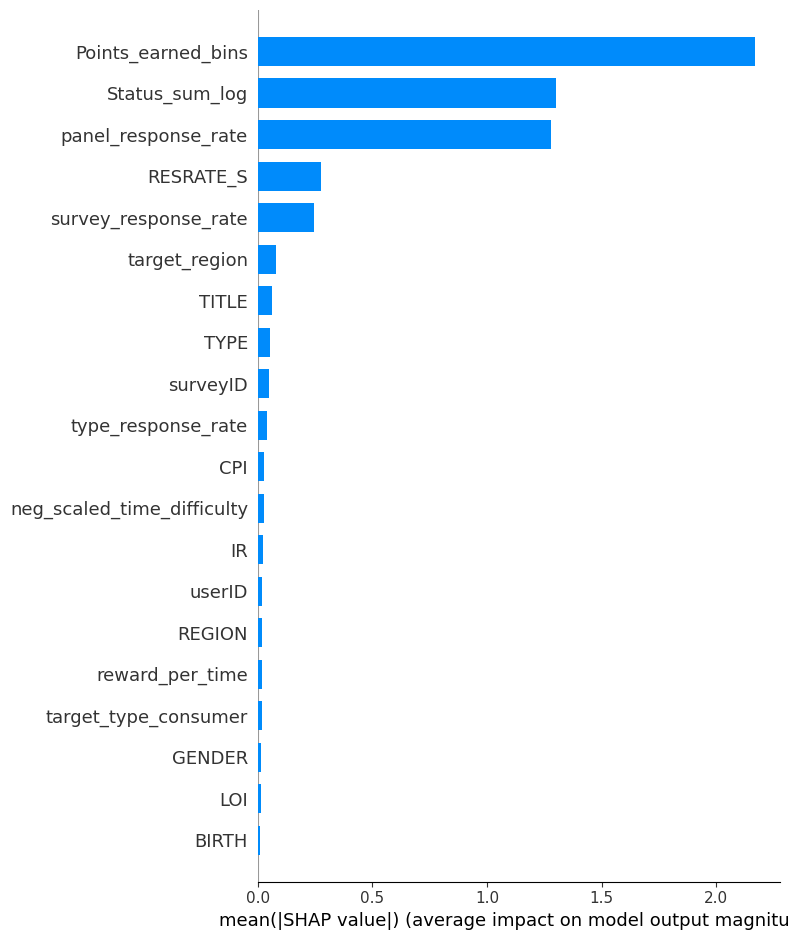

,column_name,shap_importance
30,Points_earned_bins,2.169876
31,Status_sum_log,1.299483
21,panel_response_rate,1.280240
22,RESRATE_S,0.274098
23,survey_response_rate,0.246761
27,target_region,0.080897
17,TITLE,0.062699
5,TYPE,0.051658
1,surveyID,0.048805
24,type_response_rate,0.040008


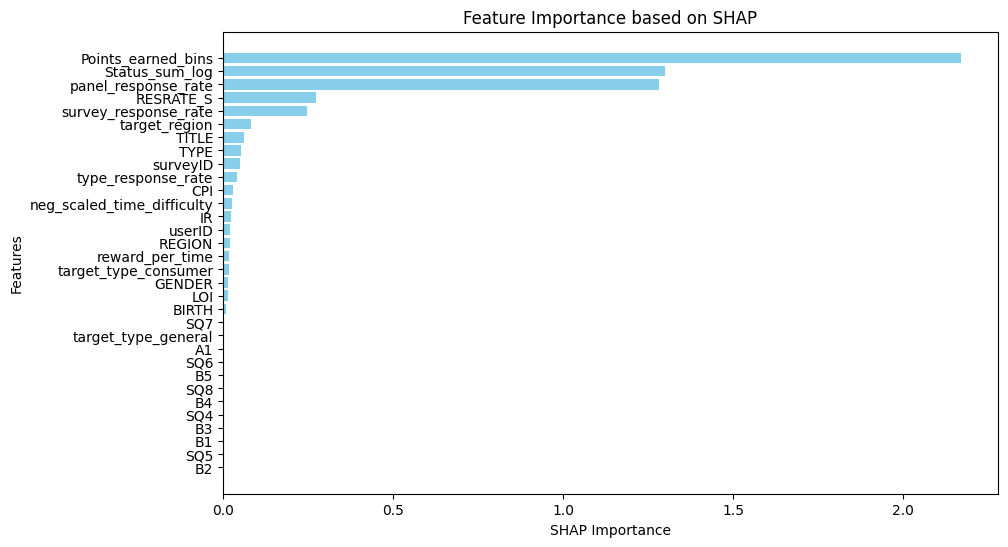

In [40]:
# LightGBM 모델 학습

X_importance = X_test

model = LGBMClassifier(random_state=0).fit(X_train, y_train)

# SHAP Explainer 생성 및 SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# SHAP Summary Plot (막대그래프)
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# SHAP 중요도 계산 (axis=0 수정)
shap_sum = np.abs(shap_values).mean(axis=0)  #

# 피처 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'column_name': X_importance.columns,
    'shap_importance': shap_sum
}).sort_values('shap_importance', ascending=False)

# 중요도 데이터프레임 출력
display(importance_df)  # Jupyter 환경에서 시각적으로 확인
# print(importance_df.head(10))  # 상위 10개만 출력

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df["column_name"], importance_df["shap_importance"], color='skyblue')
plt.xlabel("SHAP Importance")
plt.ylabel("Features")
plt.title("Feature Importance based on SHAP")
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.show()


In [41]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
SHAP_THRESHOLD = 0.0001

#32 -> 29
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]

print(X_train.shape)

(813650, 31)


In [42]:
X_train.columns

Index(['Points_earned_bins', 'Status_sum_log', 'panel_response_rate',
       'RESRATE_S', 'survey_response_rate', 'target_region', 'TITLE', 'TYPE',
       'surveyID', 'type_response_rate', 'CPI', 'neg_scaled_time_difficulty',
       'IR', 'userID', 'REGION', 'reward_per_time', 'target_type_consumer',
       'GENDER', 'LOI', 'BIRTH', 'SQ7', 'target_type_general', 'A1', 'SQ6',
       'B5', 'SQ8', 'B4', 'SQ4', 'B3', 'B1', 'SQ5'],
      dtype='object')

In [43]:
X_train

,Points_earned_bins,Status_sum_log,panel_response_rate,RESRATE_S,survey_response_rate,target_region,TITLE,TYPE,surveyID,type_response_rate,...,target_type_general,A1,SQ6,B5,SQ8,B4,SQ4,B3,B1,SQ5
0,32,1.934314,1.726479,1.861661,1.862850,1,0.632637,2,18,1.062459,...,0,0.783333,-0.683082,-0.402457,1741,-0.841438,-0.357405,-0.267413,0.56006,-0.457181
1,32,1.934314,1.726479,1.468151,1.469490,1,0.632637,2,19,1.062459,...,0,0.783333,-0.683082,-0.402457,1741,-0.841438,-0.357405,-0.267413,0.56006,-0.457181
2,32,1.934314,1.726479,-0.321342,-0.322485,1,0.632637,2,27,1.062459,...,0,0.783333,-0.683082,-0.402457,1741,-0.841438,-0.357405,-0.267413,0.56006,-0.457181
3,32,1.934314,1.726479,-0.631940,-0.633288,1,0.632637,2,28,1.062459,...,0,0.783333,-0.683082,-0.402457,1741,-0.841438,-0.357405,-0.267413,0.56006,-0.457181
4,32,1.934314,1.726479,-0.581945,-0.579869,1,0.632637,2,30,1.062459,...,0,0.783333,-0.683082,-0.402457,1741,-0.841438,-0.357405,-0.267413,0.56006,-0.457181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813645,33,0.310619,-0.327473,0.610627,0.609925,0,-1.453760,2,998,1.062459,...,1,0.783333,-0.683082,-0.402457,1476,-0.841438,-0.252530,-0.267413,0.56006,-0.510906
813646,33,0.310619,-0.327473,1.056260,1.056704,0,-1.453760,2,1127,1.062459,...,1,0.783333,-0.683082,-0.402457,1476,-0.841438,-0.252530,-0.267413,0.56006,-0.510906
813647,33,0.310619,-0.327473,0.596492,0.595356,0,-1.453760,2,1163,1.062459,...,1,0.783333,-0.683082,-0.402457,1476,-0.841438,-0.252530,-0.267413,0.56006,-0.510906
813648,33,0.310619,-0.327473,1.461437,1.459777,0,-1.362866,2,1220,1.062459,...,0,0.783333,-0.683082,-0.402457,1476,-0.841438,-0.252530,-0.267413,0.56006,-0.510906


In [44]:
### 데이터 변환
'''import numpy as np

# 전체 피처에 대해 sqrt 스케일링 적용
arbitrary_number = 1
X_train = np.sqrt(X_train + arbitrary_number)
X_test = np.sqrt(X_test + arbitrary_number)
'''

'import numpy as np\n\n# 전체 피처에 대해 sqrt 스케일링 적용\narbitrary_number = 1\nX_train = np.sqrt(X_train + arbitrary_number)\nX_test = np.sqrt(X_test + arbitrary_number)\n'

# **06. Model building**

#### 단일모델 성능 비교

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# 모델 정의
models = {
    "RandomForest": RandomForestClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "LogisticRegression": LogisticRegression(),
    "RidgeClassifier": RidgeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# 검증용 데이터 분리 (8:2)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

model_scores = {}

for name, model in models.items():
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    model_scores[name] = acc
    print(f"{name}: {acc:.4f}")



RandomForest: 0.8608
DecisionTree: 0.8187
LogisticRegression: 0.8410
RidgeClassifier: 0.8476
XGBoost: 0.8671
[LightGBM] [Info] Number of positive: 253252, number of negative: 397668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2212
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389068 -> initscore=-0.451232
[LightGBM] [Info] Start training from score -0.451232
LightGBM: 0.8646
CatBoost: 0.8693


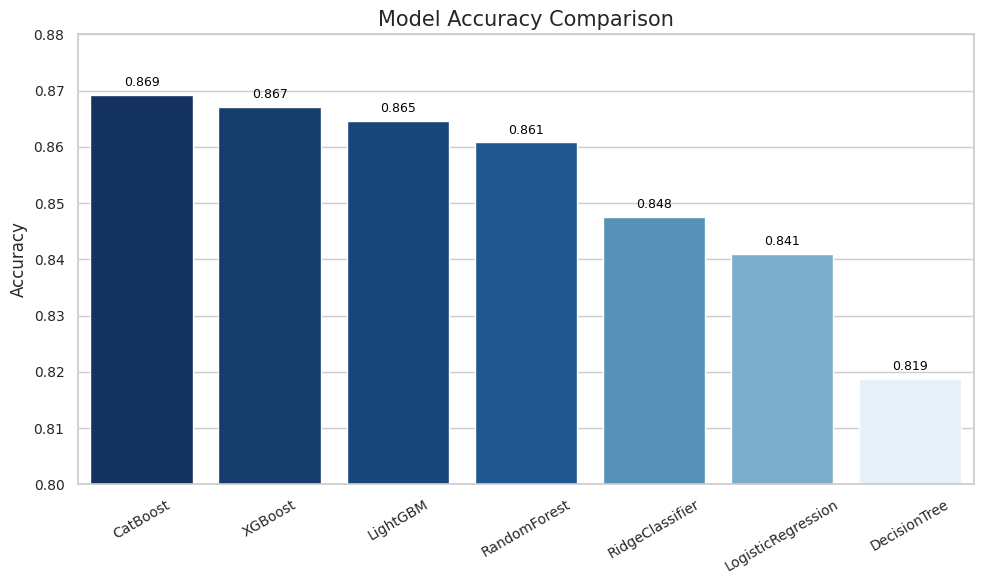

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 정확도 내림차순 정렬
sorted_scores = dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True))
df_scores = pd.DataFrame({
    'Model': list(sorted_scores.keys()),
    'Accuracy': list(sorted_scores.values())
})

sns.set(style="whitegrid")

# colormap 설정 (Blues 계열)
# DT가 완전 흰색 되지 않도록 최소값보다 살짝 더 낮게 vmin 설정
buffer = 0.005  # 색상 하한 완충
norm = mcolors.Normalize(vmin=df_scores['Accuracy'].min() - buffer,
                         vmax=df_scores['Accuracy'].max())
cmap = cm.get_cmap('Blues')
colors = [cmap(norm(val)) for val in df_scores['Accuracy']]

# 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_scores, x='Model', y='Accuracy', palette=colors)

plt.ylim(0.8, 0.88)
plt.title("Model Accuracy Comparison", fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("")
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)

# 막대 위 수치 출력
for i, row in df_scores.iterrows():
    ax.text(i, row['Accuracy'] + 0.001, f"{row['Accuracy']:.3f}",
            ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


#### CAT

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_gpu_device_count
from tqdm import tqdm

# GPU 여부 확인
device_type = 'GPU' if get_gpu_device_count() > 0 else 'CPU'

model_cb = CatBoostClassifier(
    eval_metric='Accuracy',
    loss_function='CrossEntropy',
    random_state=0,
    verbose=200,
    task_type=device_type
)

cb_pred = np.zeros((X_test.shape[0]))
accuracy_list = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for tr_idx, val_idx in tqdm(kf.split(X_train, y_train)):
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]

    train_pool = Pool(data=tr_x, label=tr_y)
    val_pool = Pool(data=val_x, label=val_y)

    model_cb.fit(train_pool)
    pred = model_cb.predict(val_pool)

    acc = accuracy_score(val_y, pred)
    accuracy_list.append(acc)

    test_pool = Pool(data=X_test)
    sub_pred = model_cb.predict_proba(test_pool)[:, 1]
    cb_pred += sub_pred

final_predictions_cb = (cb_pred / kf.get_n_splits() >= 0.495).astype(int)

print(final_predictions_cb[:10])
print(f'{model_cb.__class__.__name__} Fold 평균 Accuracy: {np.mean(accuracy_list):.4f}')


0it [00:00, ?it/s]

0:	learn: 0.8437550	total: 17.4ms	remaining: 17.4s
200:	learn: 0.8610905	total: 1.13s	remaining: 4.49s
400:	learn: 0.8640033	total: 2.19s	remaining: 3.28s
600:	learn: 0.8656778	total: 3.27s	remaining: 2.17s
800:	learn: 0.8666672	total: 4.36s	remaining: 1.08s
999:	learn: 0.8675997	total: 5.55s	remaining: 0us


1it [00:06,  6.30s/it]

0:	learn: 0.8446860	total: 6.06ms	remaining: 6.05s
200:	learn: 0.8608631	total: 1.05s	remaining: 4.16s
400:	learn: 0.8639049	total: 2.1s	remaining: 3.14s
600:	learn: 0.8655872	total: 3.16s	remaining: 2.1s
800:	learn: 0.8665182	total: 4.24s	remaining: 1.05s
999:	learn: 0.8673109	total: 5.33s	remaining: 0us


2it [00:12,  6.50s/it]

0:	learn: 0.8443357	total: 5.96ms	remaining: 5.95s
200:	learn: 0.8607632	total: 1.07s	remaining: 4.24s
400:	learn: 0.8636791	total: 2.23s	remaining: 3.33s
600:	learn: 0.8653567	total: 3.32s	remaining: 2.2s
800:	learn: 0.8664874	total: 4.38s	remaining: 1.09s
999:	learn: 0.8672402	total: 5.43s	remaining: 0us


3it [00:19,  6.62s/it]

0:	learn: 0.8440116	total: 7.22ms	remaining: 7.21s
200:	learn: 0.8608109	total: 1.08s	remaining: 4.31s
400:	learn: 0.8639326	total: 2.17s	remaining: 3.24s
600:	learn: 0.8656333	total: 3.27s	remaining: 2.17s
800:	learn: 0.8666733	total: 4.38s	remaining: 1.09s
999:	learn: 0.8674046	total: 5.55s	remaining: 0us


4it [00:26,  6.71s/it]

0:	learn: 0.8451499	total: 5.97ms	remaining: 5.97s
200:	learn: 0.8610797	total: 1.11s	remaining: 4.43s
400:	learn: 0.8639710	total: 2.22s	remaining: 3.31s
600:	learn: 0.8656117	total: 3.32s	remaining: 2.2s
800:	learn: 0.8667286	total: 4.44s	remaining: 1.1s
999:	learn: 0.8675321	total: 5.51s	remaining: 0us


5it [00:33,  6.68s/it]

[1 1 1 1 1 1 1 1 1 1]
CatBoostClassifier Fold 평균 Accuracy: 0.8662


#### LGBM

In [48]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np

model_lgbm = LGBMClassifier(
    n_estimators=4000,
    learning_rate=0.05,
    objective='binary',
    metric='binary_error',
    random_state=44
)

lgbm_pred = np.zeros((X_test.shape[0]))
accuracy_list = []
threshold = 0.5
spl = 5

kf = KFold(n_splits=spl, shuffle=True, random_state=42)

for tr_idx, val_idx in tqdm(kf.split(X_train, y_train)):
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]

    model_lgbm.fit(tr_x, tr_y, eval_metric='accuracy')
    pred = model_lgbm.predict(val_x)

    acc = accuracy_score(val_y, pred)
    accuracy_list.append(acc)
    print(acc)

    sub_pred = model_lgbm.predict_proba(X_test)[:, 1]
    lgbm_pred += sub_pred

final_predictions_lgbm = (lgbm_pred / spl >= 0.495).astype(int)

print(final_predictions_lgbm)
print(f'{model_lgbm.__class__.__name__}의 fold 평균 Accuracy는 {np.mean(accuracy_list):.4f}')


0it [00:00, ?it/s]

[LightGBM] [Info] Number of positive: 253249, number of negative: 397671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389063 -> initscore=-0.451252
[LightGBM] [Info] Start training from score -0.451252
0.8699625145947275


1it [01:24, 84.62s/it]

[LightGBM] [Info] Number of positive: 253255, number of negative: 397665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2205
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389072 -> initscore=-0.451213
[LightGBM] [Info] Start training from score -0.451213
0.8706999324033675


2it [02:49, 84.84s/it]

[LightGBM] [Info] Number of positive: 253497, number of negative: 397423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.389444 -> initscore=-0.449649
[LightGBM] [Info] Start training from score -0.449649
0.8710563510108769


3it [04:13, 84.34s/it]

[LightGBM] [Info] Number of positive: 253073, number of negative: 397847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2212
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388793 -> initscore=-0.452390
[LightGBM] [Info] Start training from score -0.452390
0.8709703189332022


4it [05:38, 84.53s/it]

[LightGBM] [Info] Number of positive: 253186, number of negative: 397734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2209
[LightGBM] [Info] Number of data points in the train set: 650920, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388966 -> initscore=-0.451659
[LightGBM] [Info] Start training from score -0.451659
0.8701898850857248


5it [07:01, 84.35s/it]

[1 1 1 ... 0 0 1]
LGBMClassifier의 fold 평균 Accuracy는 0.8706


#### XGB

In [49]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

best_params = {
    'n_estimators': 5000,
    'max_depth': 15,
    'learning_rate': 0.1,
    'subsample': 0.95,
    'colsample_bytree': 0.95,
    'gamma': 1e-8,
    'min_child_weight': 20,
    'random_state': 0,
    'eval_metric': 'error',
    'objective': 'binary:logistic',
    'verbosity': 0
}

model_xgb = XGBClassifier(**best_params)
xgb_pred = np.zeros((X_test.shape[0]))
accuracy_list = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for tr_idx, val_idx in tqdm(kf.split(X_train, y_train)):
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]

    model_xgb.fit(tr_x, tr_y)
    pred = model_xgb.predict(val_x)

    acc = accuracy_score(val_y, pred)
    accuracy_list.append(acc)
    print(acc)

    sub_pred = model_xgb.predict_proba(X_test)[:, 1]
    xgb_pred += sub_pred

final_predictions_xgb = (xgb_pred / kf.get_n_splits() >= 0.495).astype(int)

print(final_predictions_xgb)
print(f'{model_xgb.__class__.__name__}의 fold 평균 Accuracy는 {np.mean(accuracy_list):.4f}')


0it [00:00, ?it/s]

0.8606157438702144


1it [04:13, 253.98s/it]

0.8606095987218091


2it [07:20, 214.55s/it]

0.8607632274319424


3it [10:29, 202.47s/it]

0.8611688072266945


4it [13:37, 196.99s/it]

0.8583481841086462


5it [16:44, 200.92s/it]

[1 1 1 ... 0 0 1]
XGBClassifier의 fold 평균 Accuracy는 0.8603


#### 최종예측값 도출

In [50]:
avg_predictions = (final_predictions_lgbm + final_predictions_xgb + final_predictions_cb) / 3
threshold = 0.5
final_predictions = np.where(avg_predictions >= threshold, 1, 0)

#### Submission

In [51]:
# 예측 결과 길이 확인
print(len(final_predictions))

541867


In [52]:
# 제출 파일 생성
t = pd.Timestamp.now()
fname = f"(oof_hardvoting_submission)_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submission = pd.DataFrame({'ID': ID_test, 'STATUS': final_predictions})
submission.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'(oof_hardvoting_submission)_07150916.csv' is ready to submit.
